In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling

from IPython.display import clear_output
import matplotlib.pyplot as plt
import pathlib

In [14]:
tf.__version__

'2.6.0'

In [15]:
def train_val_test_split(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

def display(imgtensor, lab=None):
    plt.figure(figsize=(10, 10))
    # plt.subplot(1, numimgs, i+1)
    CLASS = ['Kelvin', 'No Kelvin']
    if lab is not None:
        plt.title(f"label: {CLASS[lab]}")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgtensor), cmap='gray')
    plt.axis('off')
    plt.show()

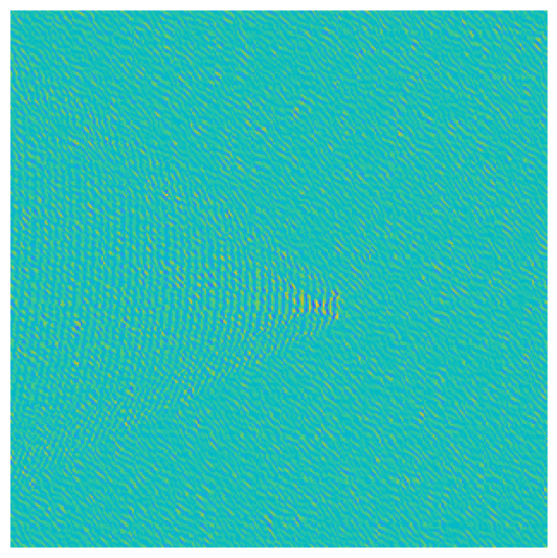

In [46]:
img = keras.utils.load_img('/srv/scratch/kelvinwakes/imgdata/ship_wake_photos8/noisyKelvin/1_Gauss_Kelvin_image.png')
shape = img.size
display(img)

In [106]:
BATCH_SIZE=16
SHAPE=(128,128,1) # (256,256) or use the shape variable above
imgdata = tf.keras.utils.image_dataset_from_directory("/srv/scratch/kelvinwakes/imgdata/ship_wake_photos8", 
                                                      image_size=SHAPE[:2], 
                                                      color_mode='grayscale',
                                                      batch_size=BATCH_SIZE, 
                                                      seed=20220317,#date                                          
                                                     )

Found 750 files belonging to 2 classes.


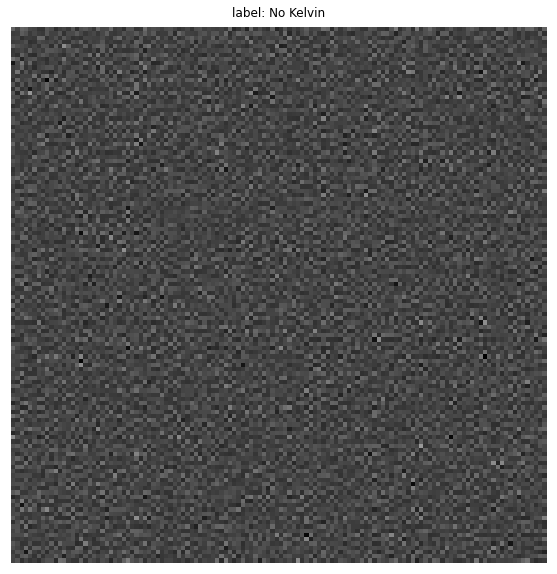

In [56]:
for img, lab in imgdata.take(1):
    i=BATCH_SIZE-1
    display(img[i], lab=lab[i].numpy())

In [107]:
DS_SIZE = len(imgdata)
train_ds, val_ds, test_ds = train_val_test_split(imgdata, ds_size=DS_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
len(train_ds), len(val_ds), len(test_ds)

(37, 4, 6)

In [108]:
# Model specification
# architecture hyperparameters
num_filters=[16,32,64] # [8,16,32], [64,32,16], [32,16,8], [8,16], [16,32], [8,32], [16,64], [16,8], [32,16], [32,8], [64,16]
num_blocks=len(num_filters)
kernel_size=3 # 5, 7
dropout=[0.1,0.1] # dropout for blocks and final layer [0.1,0.2], [0.2,0.2], [0.2,0.4]
dense_units=128 # 512, 256, 128, 64
activation='relu'

def conv_block(x, filters, kernel_size, activation, dropout, padding='same', convstrides=(1,1)):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=convstrides)(x)
    x = MaxPool2D()(x)
    # x = Dropout(dropout)(x)
    return x

inputs = tf.keras.Input(shape=SHAPE)
x = Rescaling(1/255.)(inputs)
for i in range(num_blocks):
    x = conv_block(x, 
                   filters=num_filters[i],
                   kernel_size=kernel_size,
                   activation=activation,
                   dropout=dropout[0]
                  )
x = Flatten()(x)
x = Dense(dense_units, activation=activation)(x)
# x = Dropout(dropout[1])(x)
pred = Dense(2)(x) # 2 classes

model=tf.keras.Model(inputs=inputs, outputs=pred)
model.summary()
    

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        184

In [109]:
# training hyperparameters
learning_rate=0.0005
epochs = 25

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
37/37 [==============================] - 3s 65ms/step - loss: 0.6424 - accuracy: 0.6655 - val_loss: 0.5715 - val_accuracy: 0.6562
Epoch 2/25
37/37 [==============================] - 2s 44ms/step - loss: 0.5058 - accuracy: 0.7635 - val_loss: 0.3885 - val_accuracy: 0.8594
Epoch 3/25
37/37 [==============================] - 2s 44ms/step - loss: 0.4233 - accuracy: 0.8057 - val_loss: 0.4863 - val_accuracy: 0.8281
Epoch 4/25
37/37 [==============================] - 2s 43ms/step - loss: 0.4688 - accuracy: 0.7753 - val_loss: 0.4407 - val_accuracy: 0.8281
Epoch 5/25
37/37 [==============================] - 2s 44ms/step - loss: 0.3796 - accuracy: 0.8581 - val_loss: 0.5737 - val_accuracy: 0.7969
Epoch 6/25
37/37 [==============================] - 2s 44ms/step - loss: 0.3976 - accuracy: 0.8530 - val_loss: 0.3360 - val_accuracy: 0.8438
Epoch 7/25
37/37 [==============================] - 2s 43ms/step - loss: 0.3505 - accuracy: 0.8649 - val_loss: 0.3568 - val_accuracy: 0.8281
Epoch 8/25
37

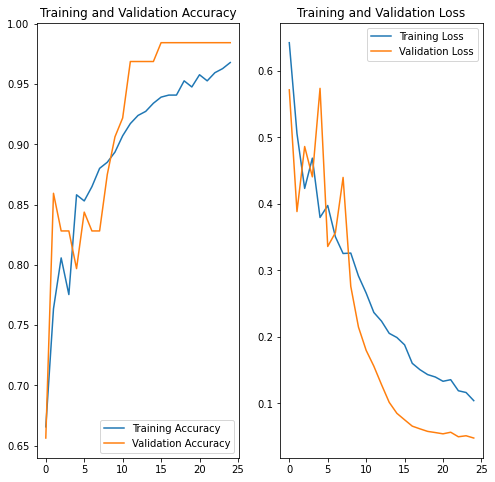

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**18/03/2022**

- Removed dropout layers as there doesn't seem to be any overfitting.
- Adjusted learning rate to 0.0005 from 0.001 (default) and batch_size to 16 from 8 to minimize fluctuations in accuracy during training

Model performs well with 128 nodes in the penultimate dense layer (as opposed to 2 nodes in Jack's thesis). This can be explained by the higher res image input (128,128) as opposed to (28,28). To prove this hypothesis I trained a model with (28,28) input images and 2 nodes in the penultimate dense layer. This model achieved 87.67% training accuracy and 85.95% val accuracy after 25 epochs. Here we can also see the need for dropout regularization as used by Jack.

In [90]:
# Model specification
# architecture hyperparameters
num_filters=[64,32,16] # [8,16,32], [16,32,64], [32,16,8], [8,16], [16,32], [8,32], [16,64], [16,8], [32,16], [32,8], [64,16]
num_blocks=len(num_filters)
kernel_size=3 # 5, 7
dropout=[0.1,0.1] # dropout for blocks and final layer [0.1,0.2], [0.2,0.2], [0.2,0.4]
dense_units=128 # 512, 256, 128, 64
activation='relu'

def conv_block(x, filters, kernel_size, activation, dropout, padding='same', convstrides=(1,1)):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=convstrides)(x)
    x = MaxPool2D()(x)
    # x = Dropout(dropout)(x)
    return x

inputs = tf.keras.Input(shape=SHAPE)
x = Rescaling(1/255.)(inputs)
for i in range(num_blocks):
    x = conv_block(x, 
                   filters=num_filters[i],
                   kernel_size=kernel_size,
                   activation=activation,
                   dropout=dropout[0]
                  )
x = Flatten()(x)
x = Dense(dense_units, activation=activation)(x)
# x = Dropout(dropout[1])(x)
pred = Dense(2)(x) # 2 classes

model=tf.keras.Model(inputs=inputs, outputs=pred)
model.summary()
    

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 16)        462

In [91]:
# training hyperparameters
learning_rate=0.0005
epochs = 25

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
37/37 [==============================] - 4s 94ms/step - loss: 0.6725 - accuracy: 0.6047 - val_loss: 0.8007 - val_accuracy: 0.5000
Epoch 2/25
37/37 [==============================] - 3s 93ms/step - loss: 0.6094 - accuracy: 0.6875 - val_loss: 0.7242 - val_accuracy: 0.6250
Epoch 3/25
37/37 [==============================] - 3s 92ms/step - loss: 0.5477 - accuracy: 0.7162 - val_loss: 0.7842 - val_accuracy: 0.6250
Epoch 4/25
37/37 [==============================] - 3s 92ms/step - loss: 0.4755 - accuracy: 0.7922 - val_loss: 0.3946 - val_accuracy: 0.8438
Epoch 5/25
37/37 [==============================] - 3s 92ms/step - loss: 0.3910 - accuracy: 0.8361 - val_loss: 0.6364 - val_accuracy: 0.6719
Epoch 6/25
37/37 [==============================] - 3s 92ms/step - loss: 0.4131 - accuracy: 0.8260 - val_loss: 0.3386 - val_accuracy: 0.8594
Epoch 7/25
37/37 [==============================] - 3s 91ms/step - loss: 0.4079 - accuracy: 0.8176 - val_loss: 0.3430 - val_accuracy: 0.8594
Epoch 8/25
37

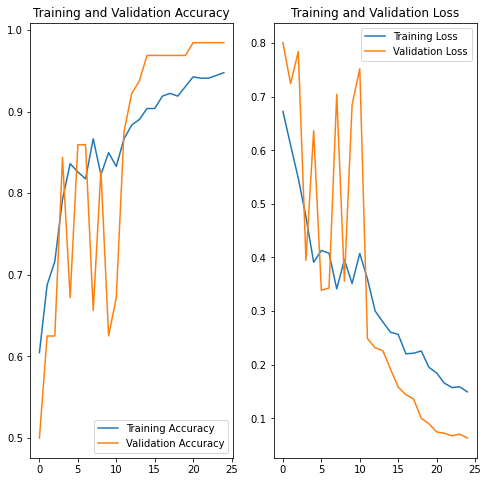

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**18/03/2022**

Above: Experiment with funneling filters \[64,32,16\] as opposed to \[16,32,64\]
Observations:
- Initial training is difficult (fluctuating val accuracy during the first 10 epochs) but end result is identical to expanding conv layers